<a href="https://colab.research.google.com/github/columbia-data-club/meetings/blob/main/2022/december-8-pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1 align="center">
PyMC: Bayesian statistics with python 

<h3 align="center">
Today's topic: Modeling spatial data with Gaussian processes in PyMC

Columbia Data Club   
December 8, 2022  
Roger Creel  
</h4>

 -----------------------------------

Source attribution: 

This notebook draws heavily on a PyMC Labs [blogpost](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/) by Luciano Paz, which itself is based on a PyMC [example](https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html) originally authored by Chris Fonnesbeck in 2017, which _itself_ is based on a foundational paper by Gelman and Hill (2006).  To paraphrase George Balanchine, "There are no new ~~steps~~ <font color="green"> code examples</font>, only new ~~combinations~~ <font color="green"> blog posts presenting them</font>."



## Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](https://www.cgenarchive.org/uploads/2/5/2/6/25269392/7758459_orig.jpg)

The EPA did a study of radon levels in 80,000 houses. There are two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota. 

#<font color="darkred"> A Big Question with geospatial data: </font>

+ How are observations separated in space connected?  
    - Is there some categorical set of features we can use to group them?
    - Should we model them all independently? 
    - Can we split the difference? 

#<font color="darkblue"> ** Switch to powerpoint ** </font>


In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (124 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2)

In [ ]:
import arviz as az
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import pandas as pd
import pymc as pm
from aesara import tensor as at
from matplotlib import pyplot as plt

# But first, let's look at some maps

It's good prractice to any modeling by looking at the data. 



In [ ]:
# Load the radon dataset and add the US FIPS prefix
df = pd.read_csv(pm.get_data("radon.csv"), index_col=0, dtype={"fips": int})
df["fips"] = "US" + df["fips"].astype("string")
county_idx, counties = df.county.factorize(sort=True)
unique_fips = df.fips.unique()

With Cartopy we can get shape files from public sources, like [Natural Earth](https://www.naturalearthdata.com/). One of these are the shape files for U.S. counties. The county shapes have a lot of meta information. One important field is called FIPS, that stands for [Federal Information Processing Standards](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standards).  

At the time the radon measurements were performed, the counties were identified using their FIPS codes, and we use these to align our observations to the corresponding shape files.

In [ ]:
# Get the state of Minnesota shapefile
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
minnesota = [
    s
    for s in reader.records()
    if s.attributes["admin"] == "United States of America"
    and s.attributes["name"] == "Minnesota"
][0]

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [ ]:
# Get Minnesota counties and neighboring counties shape files
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_2_counties"
    )
)
minnesota_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area
    < 0.01
]
minnesota_neighbor_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area > 0.5
]
counties_with_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] in unique_fips
]
counties_without_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] not in unique_fips
]
len(counties_with_measurements), len(counties_without_measurements), len(
    minnesota_neighbor_counties
)

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_2_counties.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


(85, 2, 37)

With the necessary shape files extracted, we notice something interesting. The dataset has measurements for 85 out of 87 counties from Minnesota. We will use our model to predict the expected level of radon that we should see in the remaining 2 counties and also on the 37 neighboring counties from the neighboring states. Let's see where these counties are on a map:

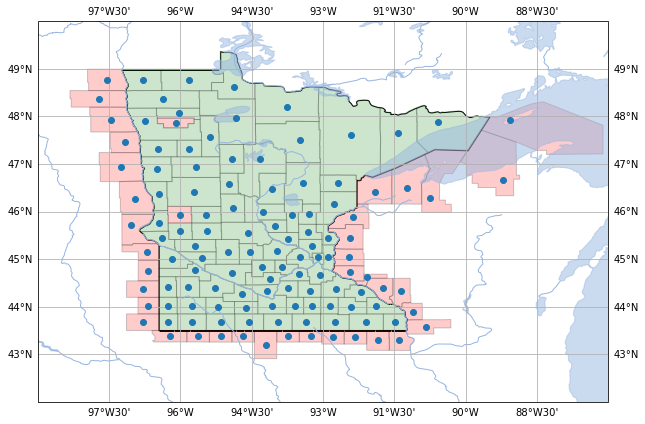

The green counties are the ones where we have at least one household measurement. The red ones are where we don't have measurements. The blue dots are points within the county. Since the radon dataset doesn't have the precise coordinates of each household, we will use the blue dot coordinates to impute the county households locations.

Now let's look at the average radon measurement for each county. To view this, we first need to use a dictionary that maps from the county measured in the radon dataframe to the shapefile record for said county.

In [ ]:
# Get a mapping from county names to latitude/longitude
# and another mapping from county names to shapefile records for plotting
county_fips = {counties[idx]: df.fips.iloc[i] for i, idx in enumerate(county_idx)}
fips_to_records = {
    record.attributes["FIPS"]: record for record in counties_with_measurements
}
county_to_records = {c: fips_to_records[county_fips[c]] for c in counties}
county_lonlat = {
    c: np.array(
        [
            county_to_records[c].attributes["longitude"],
            county_to_records[c].attributes["latitude"],
        ]
    )
    for c in counties
}
cond_counties = [
    c.attributes["NAME"].upper() for c in counties_without_measurements
] + [
    f"{c.attributes['NAME']} - {c.attributes['REGION']}".upper()
    for c in minnesota_neighbor_counties
]
county_to_records.update(
    {
        name: record
        for name, record in zip(
            cond_counties, counties_without_measurements + minnesota_neighbor_counties
        )
    }
)
cond_county_lonlat = {
    c: np.array(
        [
            county_to_records[c].attributes["longitude"],
            county_to_records[c].attributes["latitude"],
        ]
    )
    for c in cond_counties
}

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


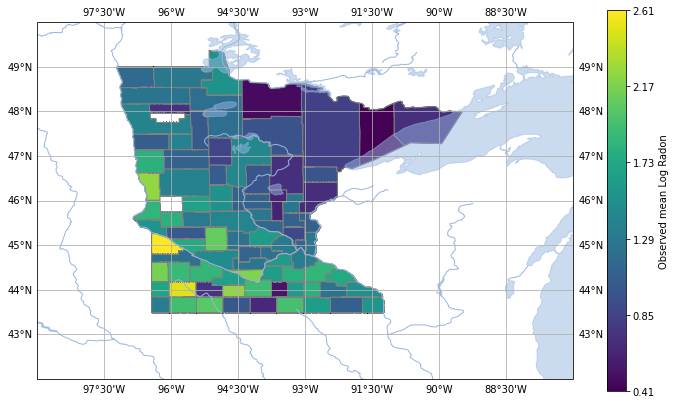

In [ ]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(
    cfeature.ShapelyFeature([minnesota.geometry], projection),
    edgecolor="k",
    facecolor="w",
)
expected_radon = df.groupby("county")["log_radon"].mean()
vmin = expected_radon.min()
vmax = expected_radon.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon[county]
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val.data),
    )

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
cbar.set_label("Observed mean Log Radon")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);

## <font color='darkred'>How would we describe the pattern in these data? </font> 



# Gaussian processes on a sphere

Even though the above plot seems flat, Earth is round (mostly):

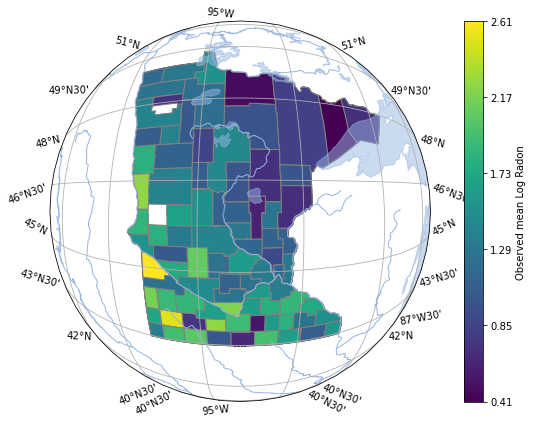


And this makes it harder for us to define Gaussian processes, but still doable: we'll build a kernel that relies on the chordal distance between points.

Chordal?!

The chordal distance simply is the distance between two points on the surface of the Earth if you could travel between them using a straight line that went through the planet. On the other hand, the Geodesic (or great circle) distance is the shortest distance between two points if one was forced to travel on the surface of the globe.

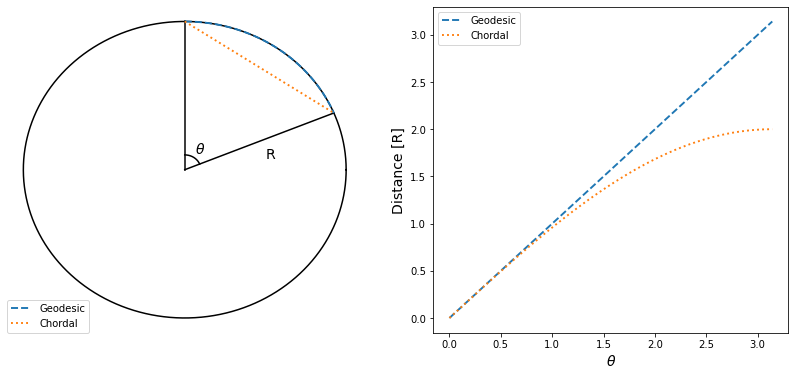

# Custom PyMC covariance kernel on a sphere


PyMC comes with many [covariance kernels](https://www.pymc.io/projects/docs/en/stable/api/gp/cov.html), but they all assume that the distance between two points is the Euclidean distance. Since we will be working with longitude and latitude pairs, we will need to write a custom ```Covariance``` subclass that operates using the metric we actually want - the chordal distance between points on a sphere.

To do this, we basically need to inherit from ```pymc.gp.cov.Stationary``` and overload the full method. This method computes the covariance between a set of points. To do this, we will copy the implementation from ```pymc.gp.cov.Matern32``` but change the distance function used. Instead of using the assumed ```euclidean_dist```, we will write a custom method, the ```chordal_dist```. To compute the chordal distance, we only need to convert the longitude/latitude coordinates into their 3-D position counterparts. The chordal distance then simply is the Euclidean distance between the 3-D position coordinates.



In [ ]:
class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * at.stack(
            [
                at.cos(lonlat[..., 0]) * at.cos(lonlat[..., 1]),
                at.sin(lonlat[..., 0]) * at.cos(lonlat[..., 1]),
                at.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = at.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return at.sqrt(at.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * at.exp(-np.sqrt(3.0) * r)

# Gaussian process geospatial model

We are finally ready to write our PyMC model of the geospatial dataset! Let's go step by step and start by simply creating the model instance, then populating it with data.



In [ ]:
X = np.array(list(county_lonlat.values()))
with pm.Model(
    coords={
        "county": counties,
        "household": df.index,
        "feature": ["longitude", "latitude"],
    }
) as m:
    _county_idx = pm.ConstantData("county_idx", county_idx, dims="household")
    _X = pm.ConstantData("county_X", X, dims=("county", "feature"))

We will assume that the observed radon comes from a state level mean plus some deviation due to the county. The county deviation will be represented by a GP. Let's first create the state level random variables.



In [ ]:
with m:
    state_mu = pm.Normal("state_mu", 0, 3)
    state_scale = pm.HalfNormal("state_scale", 0.7)

We create the GP prior for the county deviations. We will try to infer the length scale and a priori assume that it's around 200 km with a standard deviation of about 50 km.



In [ ]:
with m:
    ls = pm.Gamma("ls", mu=200, sigma=50)
    latent = pm.gp.Latent(cov_func=Matern32Chordal(2, ls),)
    county_eps = latent.prior("county_eps", _X, dims="county", jitter=1e-7)


We piece everything together and compute the expected radon measurement of each household:



In [ ]:
with m:
    county_mu = pm.Deterministic(
        "county_mu", state_mu + state_scale * county_eps, dims="county"
    )
    household_mu = county_mu[_county_idx]

Now, the final piece of the puzzle: the observational distribution. We will model the log radon values:



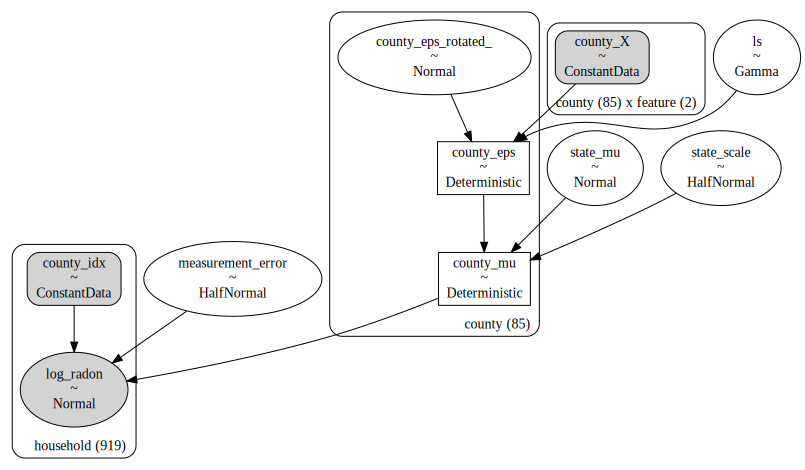

In [ ]:
with m:
    measurement_error = pm.HalfNormal("measurement_error", 0.5)
    observed = pm.Normal(
        "log_radon",
        mu=household_mu,
        sigma=measurement_error,
        observed=df.log_radon.values,
        dims="household",
    )
pm.model_to_graphviz(m)


Now let's sample from the model and see what the model learns about the measured counties:

In [ ]:
with m:
    idata = pm.sample(
        init="jitter+adapt_diag_grad", random_seed=42, chains=4, target_accept=0.9
    )

ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


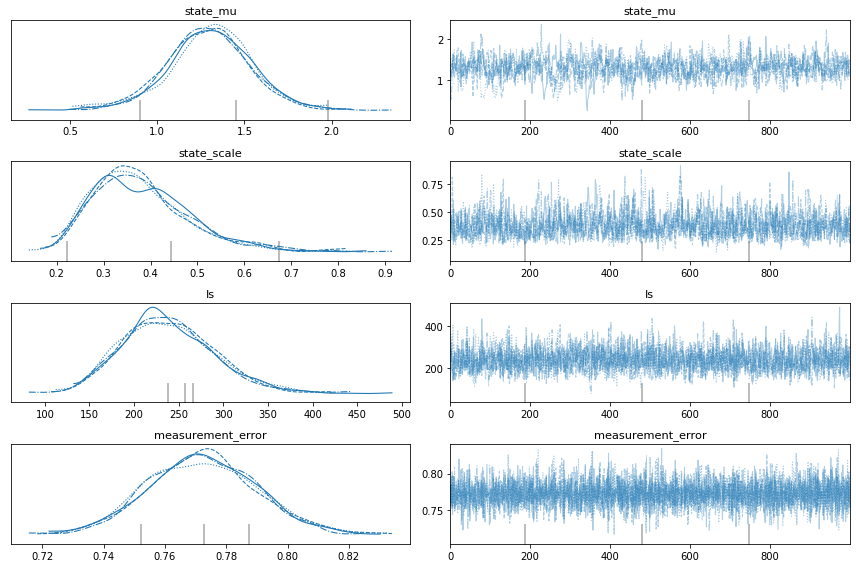

In [ ]:
axs = az.plot_trace(idata, var_names=["~county_mu", "~county_eps"], filter_vars="like")
axs[0,0].figure.tight_layout();


Finally, the most important piece, extrapolating what we learned to unobserved counties! To do this, we will have to create conditional GP's on the unobserved coordinates, and then create the conditional observed log radon random variables:



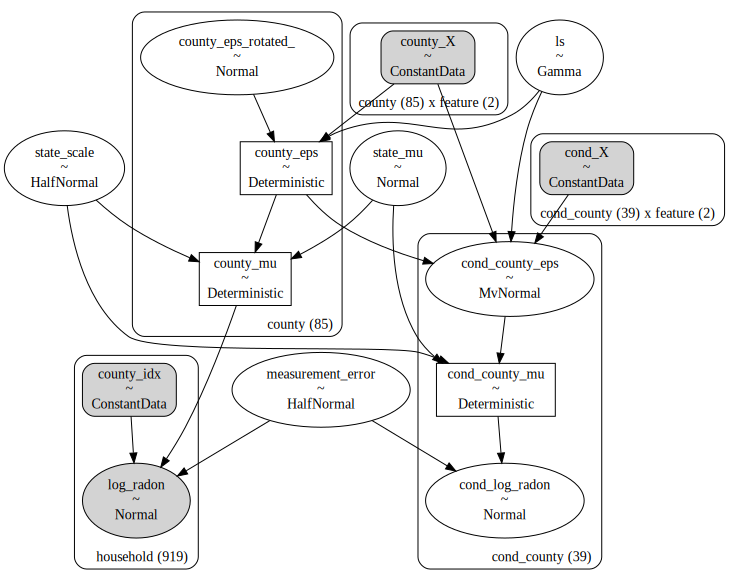

In [ ]:
cond_X = np.array(list(cond_county_lonlat.values()))
with m:
    m.add_coords({"cond_county": cond_counties})
    _cond_X = pm.ConstantData("cond_X", cond_X, dims=["cond_county", "feature"])
    cond_county_eps = latent.conditional(
        "cond_county_eps", _cond_X, jitter=1e-3, dims="cond_county"
    )
    cond_mu = pm.Deterministic(
        "cond_county_mu", state_mu + state_scale * cond_county_eps, dims="cond_county"
    )
    observed = pm.Normal(
        "cond_log_radon", mu=cond_mu, sigma=measurement_error, dims=["cond_county"],
    )
pm.model_to_graphviz(m)

Afterwards, predicting on these new counties is as easy as sampling from the posterior predictive distribution.



In [ ]:
with m:
    pp = pm.sample_posterior_predictive(
        idata, var_names=["cond_county_mu", "cond_log_radon"], random_seed=42
    )

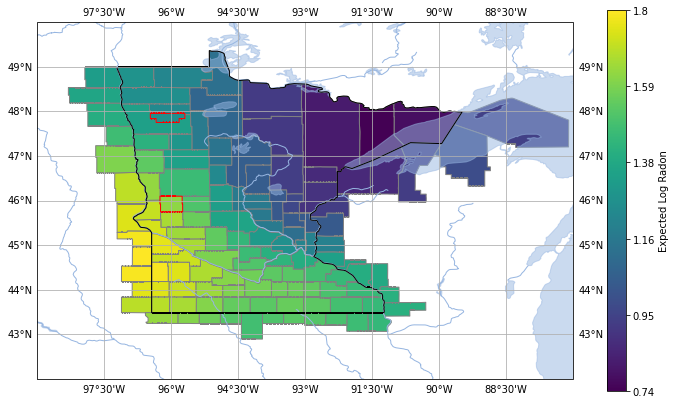

In [ ]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
expected_radon = idata.posterior.county_mu.mean(["chain", "draw"])
pp_expected_radon = pp.posterior_predictive.cond_county_mu.mean(["chain", "draw"])
vmin = min([expected_radon.min().data, pp_expected_radon.min().data])
vmax = max([expected_radon.max().data, pp_expected_radon.max().data])
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon.sel(county=county)
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val.data),
    )
for county in cond_counties:
    county_record = county_to_records[county]
    if county_record in counties_without_measurements:
        edgecolor = "red"
    else:
        edgecolor = "gray"
    val = pp_expected_radon.sel(cond_county=county)
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor=edgecolor,
        facecolor=color_getter(val.data),
    )
cmap_mappable = plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis")
cbar = fig.colorbar(cmap_mappable)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
cbar.set_label("Expected Log Radon")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.add_feature(
    cfeature.ShapelyFeature([minnesota.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);

Beautiful! Our model learned the north-east south-west pattern of radon from the observations! It also takes advantage of the discovered pattern to make predictions of the expected radon in the neighboring counties, and in the two counties without measurements in Minnesota.

